# Задача real-time предсказания исхода драки

#### Введение

В игре dota 2 существует понятие teamfight (драка). Тимфайт - это драка между персонажами двух соперничающих команд (Radiant и Dire), в которой участвуют как минимум 2 персонажа от каждой команды. Обычно тимфайты происходят при нападении на вышки, когда одна команда атакует, а другая защищается, а также при убийстве рошана, заходе на возвышенность и т.д. Драка может длиться от нескольких секунд, до нескольких минут, но обычно укладывается в 20-40 секунд. Говорят, что команда победила в драке, если в сумме она заработала больше золота на момент окончания драки, чем команда противника. 

#### Задача:

В каждый момент времени в течение тимфайта уметь определять вероятность победы Radiant в данной драке.

#### Идея решения: 

-- В каждый момент времени известны состояния всех игроков на карте. Игрок обладает некоторым влиянием на исход драки. Идея в том, чтобы уметь строить карту влияния игроков в драке в каждый момент времени. Влияние раскалывадывается на множество различных факторов/слоев (радиус атаки, скорость перемещения, кол-во урона и т.д.), которые нам и предстоит обнаружить. 

-- С одной стороны карта влияния - картинка, на которой изображена ситуация в матче, с другой - тензор, где каждый слой несет информацию о каком-то факторе влияния. Пример: положение игроков на карте, с учетом радиуса их атаки - карта влияния с 2 слоями (положение на карте в матче, радиус атаки). Для предсказания вероятности победы можно использовать нейронные сети.

-- Прелесть подхода в том, что он отражает динамику изменения веротности победы. В местах, где для одной команды вероятность сильно уменьшилась, была совершена ключевая ошибка. В тот же момент ошибка может быть отслежена компетентным человеком на видео, состоящем из последовательности карт.

## Туториал по построению карт влияния

Рассмотрим матч между Team Liquid и Team Secret в рамках LEAGUE
DreamLeague season 8

Ссылка на описание: https://www.opendota.com/matches/3595326728

Ссылка на реплей: https://drive.google.com/file/d/1yV6u9ieTaP7Oc1To1aPs_Kbr3WqctRpu/view?usp=sharing

#### Как посмотреть реплей через клиент доты?

1. Для этого необходимо скопировать `<demo_name>.dem` файл в папку replays внутри корневой директории dota 2

    `/Steam/steamapps/common/dota 2 beta/game/dota/replays`

2. Запустить dota 2 с параметром `-console`
3. Открыть консоль и прописать `playdemo replays/<demo_name>.dem`

Для дальнейшей работы потребуется файл `.jsonl`.

В `replay_log_path` укажите путь к нему

In [1]:
match_id = '3595326728'
replay_log_path = '../results/{}.jsonl'.format(match_id)

Модули matplotlib_utils и opendota можно найти по ссылке: https://github.com/theGreatVBNZ/gosu-analytics

In [2]:
import json
import requests
from IPython.display import HTML, display
from functools import lru_cache
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from matplotlib_utils import SimpleMovieWriter, display_html

from opendota import(
    query_opendota,
    show_dota2_map,
    load_hero_stats_table,
)

%matplotlib inline
warnings.filterwarnings('ignore')

### Общая инофрмация по матчу

In [3]:
# Реплей представляет из себя последовательность событий
with open(replay_log_path, 'r') as json_lines:
    # В матче есть 10 игроков, которые расположены на слотах 0..9
    # События типа interval фиксируют состояния всех игроков на карте дважды в секунду
    slot_to_name = {}
    interval_log = [[] for slot in range(10)]
    for line in json_lines:
        e = json.loads(line)
        
        if e['type'] == 'interval' and 'unit' in e:
            slot = e['slot']
            interval_log[slot].append(e)
            
        if e['type'] == 'DOTA_COMBATLOG_GAME_STATE':
            if e['value'] == 4:
                game_start = e['time']
            elif e['value'] == 5:
                game_zero = e['time']
            elif e['value'] == 6:
                game_end = e['time']
                
        if e['type'] == 'name_to_slot':
            slot_to_name[e['slot']] = e['targetname']

    name_to_slot = {v: k for k, v in slot_to_name.items()}

Список персонажей

In [4]:
slot_to_name

{0: 'npc_dota_hero_invoker',
 1: 'npc_dota_hero_doom_bringer',
 2: 'npc_dota_hero_tusk',
 3: 'npc_dota_hero_wisp',
 4: 'npc_dota_hero_tiny',
 5: 'npc_dota_hero_bounty_hunter',
 6: 'npc_dota_hero_life__stealer',
 7: 'npc_dota_hero_witch_doctor',
 8: 'npc_dota_hero_brewmaster',
 9: 'npc_dota_hero_leshrac'}

Игровое время в логе смещено на константу game_zero

In [5]:
print('Длительность матча по часам доты: {:2.2f}'.format((game_end - game_zero) / 60))
print('Длительность реплея с учетом пиков: {:2.2f}'.format(game_end / 60))

Длительность матча по часам доты: 32.87
Длительность реплея с учетом пиков: 48.12


Interval - информация о состоянии игрока в некоторый момент времени

In [6]:
slot = 0
player_state = interval_log[slot][1000]
print('Время по игровым часам: {:2.2f}'.format((player_state['time'] - game_zero) / 60))
print('\nСостояние:')
player_state

Время по игровым часам: 6.84

Состояние:


{'assists': 1,
 'camps_stacked': 0,
 'creeps_stacked': 0,
 'deaths': 0,
 'denies': 8,
 'firstblood_claimed': 0,
 'gold': 1873,
 'health': 900,
 'hero_id': 74,
 'hero_inventory': [{'cooldown': 0.0, 'id': 'item_boots'},
  {'cooldown': 0.0, 'id': 'item_faerie_fire', 'num_charges': 1},
  {'cooldown': 0.0, 'id': 'item_infused_raindrop', 'num_charges': 5},
  {'cooldown': 0.0, 'id': 'item_magic_wand', 'num_charges': 11},
  {'cooldown': 0.0, 'id': 'item_null_talisman'},
  {'cooldown': 0.0, 'id': 'item_null_talisman'}],
 'hero_stash': [],
 'kills': 0,
 'level': 6,
 'lh': 25,
 'life_state': 0,
 'max_health': 900,
 'max_mana': 698.9382,
 'nearby_creep_death_count': 61,
 'obs_placed': 0,
 'observers_placed': 0,
 'pred_vict': False,
 'randomed': False,
 'roshans_killed': 0,
 'rune_pickups': 1,
 'sen_placed': 0,
 'slot': 0,
 'stuns': 3.4656253,
 'teamfight_participation': 0.33333334,
 'tick': 41134,
 'time': 1325.7645,
 'towers_killed': 0,
 'type': 'interval',
 'unit': 'CDOTA_Unit_Hero_Invoker',
 'v

### Информация по тимфайтам

Найдем временные рамки тимфайтов. Более подробно о структуре тимфайтов можно посмотреть по ссылке: 

https://github.com/theGreatVBNZ/gosu-analytics/blob/master/Teamfights.ipynb

In [7]:
TEAMFIGHTS_QUERY = '''
SELECT
    matches.teamfights
FROM
    matches
WHERE
    matches.match_id = {}
'''.format(match_id)

In [8]:
teamfights = query_opendota(TEAMFIGHTS_QUERY)['teamfights'][0]

Информация о пятой с конца драке в игре. Также её можно посмотреть в опендоте (пятая справа на временной полосе). Почему именно она? Потому что она была возле рошана, а это всегда интересно.

https://www.opendota.com/matches/3595326728/teamfights

In [9]:
teamfights[-5]

{'deaths': 7,
 'end': 1383,
 'last_death': 1368,
 'players': [{'ability_uses': {'invoker_alacrity': 2,
    'invoker_chaos_meteor': 1,
    'invoker_cold_snap': 1,
    'invoker_emp': 1,
    'invoker_exort': 31,
    'invoker_ice_wall': 1,
    'invoker_invoke': 8,
    'invoker_quas': 34,
    'invoker_tornado': 1,
    'invoker_wex': 32},
   'buybacks': 0,
   'damage': 728,
   'deaths': 1,
   'deaths_pos': {'116': {'138': 1}},
   'gold_delta': 122,
   'healing': 135,
   'item_uses': {'magic_wand': 1},
   'killed': {'npc_dota_hero_leshrac': 1},
   'xp_delta': 572,
   'xp_end': 10973,
   'xp_start': 10402},
  {'ability_uses': {'doom_bringer_doom': 1, 'doom_bringer_scorched_earth': 1},
   'buybacks': 0,
   'damage': 1241,
   'deaths': 1,
   'deaths_pos': {'108': {'114': 1}},
   'gold_delta': 143,
   'healing': 525,
   'item_uses': {'ancient_janggo': 1,
    'dust': 1,
    'force_staff': 2,
    'magic_wand': 3,
    'phase_boots': 6},
   'killed': {},
   'xp_delta': 1613,
   'xp_end': 9635,
   'xp

В первую очередь нас интересуют вренные рамки драки

In [10]:
current_fight = teamfights[-5]
tf_start = current_fight['start']
tf_end = current_fight['end']
print('Драка длилась с {:02d}:{:02d} по {:02d}:{:02d}'.format(tf_start // 60, tf_start % 60, tf_end // 60, tf_end % 60))
print('В секундах: c {} по {}'.format(tf_start, tf_end))

Драка длилась с 21:54 по 23:03
В секундах: c 1314 по 1383


Далее нужно определить победителя драки. Будем говорить, что команда победила в драке, если суммарно она заработала больше золота, чем команда противника.

In [11]:
radiant_gold = sum([player['gold_delta'] for player in current_fight['players'][0:5]])
dire_gold = sum([player['gold_delta'] for player in current_fight['players'][5:10]])
radiant_win = True if radiant_gold > dire_gold else False
print('Radiant gold: ', radiant_gold)
print('Dire gold: ', dire_gold)
print('Radiant win? ', radiant_win)

Radiant gold:  1885
Dire gold:  1214
Radiant win?  True


Найдем положения игроков на карте во время драки tf_positions

In [12]:
tf_positions = [[] for slot in range(10)]
for state in zip(*interval_log):
    for slot in range(10):
        player_state = state[slot]
        if tf_start <= player_state['time'] - game_zero <= tf_end:
            tf_positions[slot].append({
                'x': player_state['x'],
                'y': player_state['y'],
                'slot': slot,
                'team': 0 if slot < 5 else 1,
                'team_color': 'lawngreen' if slot < 5 else 'red',
                'time': player_state['time'] - game_zero,
            })

list_df_positions - список из DataFrame(), где каждая таблица содержит 10 строк - состояния игроков в данную секунду

In [13]:
list_df_positions = [pd.DataFrame(list(pos)) for pos in zip(*tf_positions)]

Состояния игроков в начальный момент драки

In [14]:
list_df_positions[0]

,slot,team,team_color,time,x,y
0,0,0,lawngreen,1314.4091,110,138
1,1,0,lawngreen,1314.4091,110,140
2,2,0,lawngreen,1314.4091,110,130
3,3,0,lawngreen,1314.4091,104,138
4,4,0,lawngreen,1314.4091,110,140
5,5,1,red,1314.4091,104,156
6,6,1,red,1314.4091,130,126
7,7,1,red,1314.4091,130,126
8,8,1,red,1314.4091,140,120
9,9,1,red,1314.4091,124,122


### Пример построения карты влияния

Скачиваем описание персонажей, они потребуются для того, чтобы определить радиус атаки.

In [15]:
df_heroes = load_hero_stats_table()
display(df_heroes.columns)

Index(['1_pick', '1_win', '2_pick', '2_win', '3_pick', '3_win', '4_pick',
       '4_win', '5_pick', '5_win', '6_pick', '6_win', '7_pick', '7_win',
       'agi_gain', 'attack_range', 'attack_rate', 'attack_type', 'base_agi',
       'base_armor', 'base_attack_max', 'base_attack_min', 'base_health',
       'base_health_regen', 'base_int', 'base_mana', 'base_mana_regen',
       'base_mr', 'base_str', 'cm_enabled', 'hero_id', 'icon', 'id', 'img',
       'int_gain', 'legs', 'localized_name', 'move_speed', 'name',
       'primary_attr', 'pro_ban', 'pro_pick', 'pro_win', 'projectile_speed',
       'roles', 'str_gain', 'turn_rate'],
      dtype='object')

In [16]:
df_match_heroes = df_heroes[df_heroes['name'].isin(slot_to_name.values())]
df_match_heroes['slot'] = df_match_heroes.name.apply(lambda name: name_to_slot[name])
df_match_heroes = df_match_heroes.sort_values('slot')
df_match_heroes

,1_pick,1_win,2_pick,2_win,3_pick,3_win,4_pick,4_win,5_pick,5_win,...,name,primary_attr,pro_ban,pro_pick,pro_win,projectile_speed,roles,str_gain,turn_rate,slot
72,6992,3360,38114,18427,96170,47072,143546,70678,98379,49188,...,npc_dota_hero_invoker,int,17.0,25.0,12.0,900,"[Carry, Nuker, Disabler, Escape, Pusher]",2.2,0.5,0
67,1674,815,8515,4023,20768,9876,34699,17097,32672,16631,...,npc_dota_hero_doom_bringer,str,125.0,122.0,58.0,900,"[Carry, Disabler, Initiator, Durable, Nuker]",3.5,0.5,1
98,2481,1113,11994,5269,28801,13109,45596,20876,37892,17542,...,npc_dota_hero_tusk,str,330.0,280.0,127.0,900,"[Initiator, Disabler, Nuker]",3.0,0.7,2
89,654,249,2581,995,5319,2014,7081,2687,5039,1887,...,npc_dota_hero_wisp,str,8.0,9.0,4.0,1200,"[Support, Escape, Nuker]",2.2,0.7,3
18,2967,1279,11068,4806,23351,10147,31892,13918,25309,11262,...,npc_dota_hero_tiny,str,436.0,254.0,144.0,900,"[Carry, Nuker, Pusher, Initiator, Durable, Dis...",3.3,0.5,4
60,5562,2740,20220,9694,38091,19014,49526,25377,35350,18596,...,npc_dota_hero_bounty_hunter,agi,344.0,93.0,49.0,900,"[Escape, Nuker]",2.1,0.6,5
28,3492,1766,17846,9089,40044,20467,55339,28535,37205,19000,...,npc_dota_hero_witch_doctor,int,53.0,205.0,90.0,1200,"[Support, Nuker, Disabler]",2.1,0.5,7
76,1240,663,5214,2737,11860,6294,17767,9419,15204,8061,...,npc_dota_hero_brewmaster,str,268.0,187.0,94.0,900,"[Carry, Initiator, Durable, Disabler, Nuker]",3.2,0.6,8
50,867,394,3613,1714,7303,3283,9211,4162,6060,2750,...,npc_dota_hero_leshrac,int,4.0,13.0,4.0,900,"[Carry, Support, Nuker, Pusher, Disabler]",1.8,0.5,9


Рисуем положение игроков в драке с учетом радиуса атаки

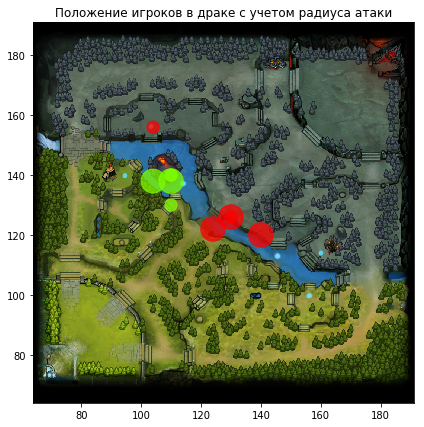

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
show_dota2_map()
plt.title('Положение игроков в драке с учетом радиуса атаки')

scat = ax.scatter(
    list_df_positions[0].x, list_df_positions[0].y,
    c=list_df_positions[0].team_color,
    s=df_match_heroes.attack_range, # Величина точки на карте задается рэнжом атаки героя
    alpha=0.75
)

Видео

In [18]:
def update(i):
    scat.set_offsets(list_df_positions[i][['x', 'y']].values)
    return scat, 
    
anim = animation.FuncAnimation(fig, update, interval=200, blit=True)

try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except RuntimeError:
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))
    pass

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAH5ZG1kYXQAAAKtBgX//6ncRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzk1IGFhYTlhYTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49NSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNo
PTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFw
bWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAABNDhliIQA
FP/+98dPwKbo+WbLnUU9ITCK2PpIKL1Y7NAydQAAAwAAAwAMaPmr5xuDgKyhgAAEjLef8I8fwANf
TN9HLPdDiKiJOq6pE2FyG9z5qEVWeEydsqkQlaslScq3wHa+oUjVCeKMykdCwn4M+1/TjS0VUEjW
nSL89Pyxy78biGcJB6m/NVbuav3OgPoreyaAmPGfMpgpT5/K5pNwyv8K0dGak7pnoV41NbJD9DnM
W2TIh6rqjWjFLPbtGd32jQeonRLwLU1CZcMyVmktpyckCxzKAFrILJyPurvVzpO0KD70d5X9yIdr
ckS/ILQ6KYFnz9xNfchEEs4Ulaz6krRTGibMskabt3ABRtIHy/SNQdBzXRlOkTwGTFVzduOYjAsa
4qxMi4Wc/1DwOBQj+Zw2Sj8jT/pV7i0tH74L1d7XxvfjM0j5FE9CuTRJmVTrLxmBH1LcFDbiHJSY
9Z6BZ/vRqDAnW8xK7/60Yy1pdJR3Om1VbJL4IOno1U4bsZKbFdJQKJmvnzlT8VZrkNIEClBYZ7ox
YrAubvqF7tLFTAcHVvtbyQItDaAWBJZm3oQDuRZcFhTbCmhg2p1JYbk9htJuW/DibUhy8irJcWN1
G9MDeLRUC9s5CYYnRWCk5lu74W9nm6dtaF1KPn3y810dMdjAcpSF0DL//bS08xBGI5sB0bHZGrqo
72gpgiT0W5yBqhdTr8nO/u1MP6rOjjC3OFGfTqKXCqhrt5OWdBjcMdaOaPXIx/o9vm44novNg/Re
+4qRqoyh/m5i3AzjlGS/70GHHb3wNNxOYo7eiSRoZRaNziCDYnB/rns9Ad8s+sHnUU0iTaeUz25P
N1Cwi8O/PT9n3Et+E2lfKaoZ++kjC90UJYvb2hY67nIo6E5excgmIkoxMP7k+dtFQHtNhYn4Ze9r
5U4hdKsscImuQjEthaXLZQmkHXFXCPEX2O55PLUfGsVsoeZvOFflilOC58MgJALOUMPkT66uJjUa
JtH6VgnK1UB/dIH7WFZEh/cSL6BKH+ptn1YPDsDTOqDf6PsWukDFKUwvKPtbpLWeWSUVqxmymg3I
uWCNly3oRms9lXNQDBlMWGemUeaHbDSR4s0veacE3+DZUALFqHabHX5CLtaEDRKbaUKEb0o/UwR/
mHrmxPft6FlVMST9n6sJKNUUvlgXAMgeFEv2F6tQBzbiCaALiUyAf0o260UNPgHx9wIwhqGmd7JF
sYXr4z1L9dfvpHDqCILBdxEj8V2HW9O7Ig/qzxzu+HUpVRdMpAS8LdbilRuNrNDL/PwU/1xrOnX0
8MH4DjU94/HSyXVNJjA8LS8wA+9OSvImyWDU9+uPiw138My46hCLVWmwUxwWC2GSioqHlOJbo2V2
wirdW0Wrrbch2Q5Z85vCfpADuDyQWtZSidDRHeWN4ZWnrK4VU102azcFRsOeJoI9l4RvPiAXlT+t
2VMGALorVEH4IwdyI7XBUqNsSj7zCYUyjWqywzODcGA2qVfVEbKFaObr3XbhU3fZMmLA/lZzgWSQ
LlYnTeUiiblQbKgMG3VQrCHKZNrVyNYK+PakNRg3OBmWKEzO99d8CYtk1xWrKCRhpReDiupgarQm
18xMnXfjIHtnZ0FWM7bbs8ih/znRKcNa/sg3WR2x295rJiWfNVFXUpZSvF8U2rm56tqUSQkFMf6h
+FTD5zSxm4ec4Kc7BIIQZ6tDFIaAfyM+VHgIC+x8cWEeUO0a+mDv7QGLtM38mLeJGR++aqTupiAU
bqsuqIfHpQk+kRtmbR9KzjNObdw33w6nO+xavLm92RWJGbz43nvO8g53bxUTyu8bcxK831CWy6Q+
cIqpWyg7euaLzAu/ZTArrJ4t3IA4bT7knnDsgCobaffDstpiQo5pdeMTcpJKPar/rgFYHmFTD4W8
7rCpVV3kDwRQbRTZsSU2QgWxu7BJ43Uo55Lf/uje5JmbeIedef7/rGarKoVMFoeceecrV8ULJULq
aRXQHKdwpAq7irMZ0dkXnqKv7ghZyrA6rCWoF6l4fN78DxfVTJVbQt5lTp1q4cCEDrLx6UCnJC3v
m4u8YpDrYIaiMEDRMse4AyL797p0ceR4ESn3nyJs0Yz9J1iKBAe8f2C615r28T/Ymm7pXnsON1B0
PLXMgV61LQdNrDjN/JWTi/95EhFNlnEJ/2Y7tXcVg8Na8qwNkXl9vXib7OKBWQcdbZwXepXVbsxh
DPlplFrijMQGJBzFbs8pt4enLQ0HzNb6KjKuhMjEIyf44mhYVDKpE7cvuyOtliVAMbNF6OzWZyBW
NvuI7NPtEzeSs44vc1lvzwWgqjOZJ8FW+CyRRF4SUisrLZrgsMSqqEZzfRPn1anoaZZcK8Vievik
Kso24T+XhVBI/7XI8x1Mu9fZIcPpf6P000NRs+rP7tKklGuYKAGqxhua0YwEBn60inpf0/VDyMEc
hEmeg4x09qD6ah6XGKhP2rBwzlVB+GdlH/LcQyp1bRITIQSO+HLY1UjLTqSEu+UfLK9DmbhPdtvT
gtUTYYx0pTEeAbGkNafY+AekrDyun6MxDvziRhWxJzMFEk9NdMoe5Z+QHLbBk7Fen/gvJsIODxC5
8zGU790cLrcpioK/B0KdpcKz/jTP6xWKmGjMynHdEmjWkoe7dg8wjSQvQOSjD1k8d+wJcLw+sXmJ
l1qCqvoiweKlj9N+SmFeFzTHUAZrb9RD+iryhwuZyc1fNs/li1l7Lu7qtOPf+2lSyjtGrrD3c9rO
LnqT1tdT1gE7yPx3TEvV1BVfCplHf958DypdLv6pp7q4Kc33Ltawk5I3ORsZpwm3XpWDI4j1AgAJ
/ddEZJgS87iwSxJpcXR/lq+QqAdEc28Gl7+p3DM4St0PghshA0n8I1LE98CV2T27w2vd4GMqhRIH
b9plktH2XedoFoWWcpJP0

Как из картинок получать карты влияния игроков в драке?

In [19]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    tensor = np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    return tensor

(64.0, 191.0, 64.0, 191.0)

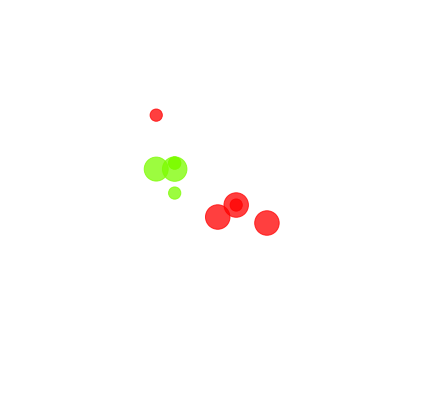

In [20]:
fig, ax = plt.subplots(figsize=(7, 7), )
ax.set_xlim(64, 127+64)
ax.set_ylim(64, 127+64)
scat = ax.scatter(
    list_df_positions[0].x, list_df_positions[0].y,
    c=list_df_positions[0].team_color,
    s=df_match_heroes.attack_range, # Величина точки на карте задается рэнжом атаки героя
    alpha=0.75
)
plt.axis('off')

Соответствующий тензор (bbox_inches="tight" уберает белые полосы по бокам, если делать savefig вместо fig2rgb_array)

In [21]:
influence_map = fig2rgb_array(fig)
display(influence_map.shape)
influence_map

(504, 504, 3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

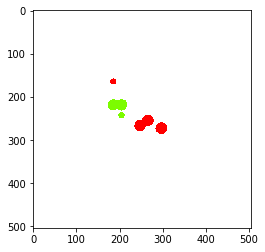

In [22]:
plt.imshow(influence_map)